# HW2   - CMPE 547

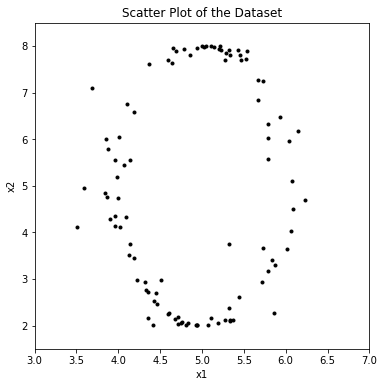

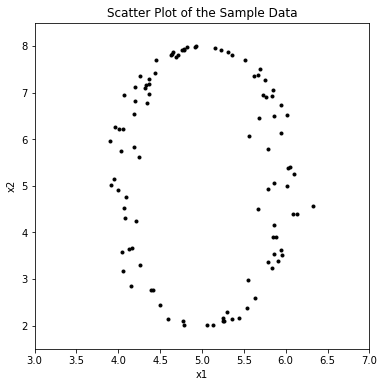

In [50]:
# 1. Scatter plot of the Dataset
%reset -f
import numpy as np
import matplotlib.pyplot as plt
D=np.loadtxt('hw2_data.txt')
plt.figure(figsize=(6,6))
plt.plot(D[:,0],D[:,1],'k.')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter Plot of the Dataset')
plt.ylim([1.5,8.5])
plt.xlim([3,7])
plt.show()

# 3. Sapmle Data for propesed Generative Model
N = 100
center=np.mat([5,5]).T
sigma = 0.12
theta = np.mat([1,3]).T
w=np.random.rand(1,N)
x1=np.cos(2*np.pi*w)
x2=np.sin(2*np.pi*w)
u=np.array([x1[0],x2[0]])

e=sigma*x1*np.random.randn(2,N)
theta=np.ones((2,N))
theta[1,:]=3
x=theta*u+center+e

# 4. Scatter Plot of the Sample Data
plt.figure(figsize=(6,6))
plt.plot(x[0,:],x[1,:],'k.')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter Plot of the Sample Data')
plt.ylim([1.5,8.5])
plt.xlim([3,7])
plt.show()


# 2. Generative Model

\begin{eqnarray}
w & \sim & \mathcal{U}(0,1) \\
u & = & \left(\begin{array}{c} \cos(2\pi w) \\ \sin(2\pi w) \end{array}\right) \\
e & \sim & \mathcal{N}\left(0, (\sigma u_1)^2 \left(\begin{array}{cc}  1 & 0\\  0 & 1\\\end{array}\right) \right) , \  where \     u_1=cos(2\pi w) \\
x & \sim & \left(\begin{array}{c} \theta_1 \\ \theta_2 \end{array} \right)u + center + e
\end{eqnarray}
